In [30]:
import tensorflow as tf
print(tf.version.VERSION)
!git clone --depth 1 -b v2.4.0 https://github.com/tensorflow/models.git


2.6.4
Cloning into 'models'...
remote: Enumerating objects: 752, done.
remote: Counting objects: 100% (752/752), done.
remote: Compressing objects: 100% (651/651), done.
remote: Total 752 (delta 166), reused 373 (delta 91), pack-reused 0
Receiving objects: 100% (752/752), 1.22 MiB | 11.54 MiB/s, done.
Resolving deltas: 100% (166/166), done.
Note: switching to '47e65c1aedf4181faaf5535f06c26dbcb083c4ad'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false



In [31]:
# install requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tfx-bsl 1.9.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.66.0 which is incompatible.
tfx-bsl 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tfx-bsl 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<3,>=1.15.5, but you have tensorflow 2.6.4 which is incompatible.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.1 w

In [32]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import wandb
from wandb.keras import WandbCallback


/opt/conda/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.4 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [33]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")


TF Version:  2.6.4
Eager mode:  True
Hub version:  0.12.0
GPU is NOT AVAILABLE


In [100]:
# TO LOAD DATA FROM ARCHIVE LINK
import pandas as pd
from sklearn.model_selection import train_test_split


Data = pd.read_csv('../input/mental-health-social-media/Mental-Health-Twitter.csv')
twitter_text = Data[['post_text','label']]
twitter_text.head(2)



,post_text,label
0,It's just over 2 years since I was diagnosed w...,1
1,"It's Sunday, I need a break, so I'm planning t...",1


In [65]:
!pip install nltk
import nltk
nltk.download('punkt')

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

!pip install textblob
from textblob import TextBlob

import re
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [66]:
from textblob import Word
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()
nltk.download("wordnet")

sw = stopwords.words('english')
def normalize_opinion(text):
  
    # define emojis
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    
    
    # lowercase
    s = text.lower()
   
    # Change 'n't to 'not'
    s = re.sub(r"n\'t", " not", s)
    s = re.sub(r"n\’t", " not", s)
    # Change ''s to 'is'
    s = re.sub(r"\'s", " is", s)
    s = re.sub(r"\’s", " is", s)
    # Change ''ll to 'will'
    s = re.sub(r"\'ll", " will", s)
    s = re.sub(r"\’ll", " will", s)
    # Change ''m to 'am'
    s = re.sub(r"\'m", " am", s)
    s = re.sub(r"\’m", " am", s)
    # Change ''ve to 'have'
    s = re.sub(r"\'ve", " have", s)
    s = re.sub(r"\’ve", " have", s)
    # Change ''re to 'are'
    s = re.sub(r"\'re", " are", s)
    s = re.sub(r"\’re", " are", s)
    
    # Remove numbers
    s = re.sub(r'[0-9]','',s)

    # Remove @name - tags/mentions
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Remove hashtags
    s = re.sub(r'#[A-Za-z0-9_]+', ' ', s)
    # Remove web links
    s = re.sub(r'http\S+', ' ', s)
    
    # Remove emojis
    s = emoji_pattern.sub(r'', s)

    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    s = [word.lower() for word in s.split() if word.lower() not in sw]
    
    s = " ".join(s) #removing stopwords
    

    # Remove words of length shorter than 2   
    s = [i for i in s.split() if len(i)>2]
    s = ' '.join(s)

    return  s

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [71]:
twitter_text['text'] = twitter_text['post_text'].apply(lambda x: normalize_opinion(x))

In [99]:
df = twitter_text[['label','text']]

print(df.shape)
#df.head(10)

(20000, 2)


In [76]:
train_df, remaining = train_test_split(df, random_state=42, train_size=0.1, stratify=df.label.values)
valid_df, _ = train_test_split(remaining, random_state=42, train_size=0.01, stratify=remaining.label.values)
print(train_df.shape)
print(valid_df.shape) 


(2000, 2)
(180, 2)


In [82]:
with tf.device('/cpu:0'):
    train_data = tf.data.Dataset.from_tensor_slices((train_df['text'].values, train_df['label'].values))
    valid_data = tf.data.Dataset.from_tensor_slices((valid_df['text'].values, valid_df['label'].values))
    # lets look at 3 samples from train set
    for text,label in train_data.take(3):
        print(text)
        print(label)


tf.Tensor(b'happy new year including many enemies fought lost badly kno', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(b'horse meat sold countries everyone eat horses chowing cows', shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(b'ashleys pastry shop', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


In [84]:
# Setting hyperparameters

config = {'label_list' : [0, 1],
          'max_seq_length' : 128, # maximum length of (token) input sequences
          'train_batch_size' : 32,
          'learning_rate': 2e-5,
          'epochs':5,
          'optimizer': 'adam',
          'dropout': 0.5,
          'train_samples': len(train_data),
          'valid_samples': len(valid_data),
          'train_split':0.1,
          'valid_split': 0.01
         }


In [85]:


bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2',
                            trainable=True)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy() # checks if the bert layer we are using is uncased or not
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)


In [87]:
# This provides a function to convert row to input features and label, 
# this uses the classifier_data_lib which is a class defined in the tensorflow model garden we installed earlier


def create_feature(text, label, label_list=config['label_list'], max_seq_length=config['max_seq_length'], tokenizer=tokenizer):
  
    example = classifier_data_lib.InputExample(guid = None,
                                            text_a = text.numpy(), 
                                            text_b = None, 
                                            label = label.numpy())
 
    feature = classifier_data_lib.convert_single_example(0, example, label_list,
                                    max_seq_length, tokenizer)


    return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)


In [88]:
def create_feature_map(text, label):
   
    input_ids, input_mask, segment_ids, label_id = tf.py_function(create_feature, inp=[text, label], 
                                                                  Tout=[tf.int32, tf.int32, tf.int32, tf.int32])
    max_seq_length = config['max_seq_length']


    # py_func doesn't set the shape of the returned tensors.
    input_ids.set_shape([max_seq_length])
    input_mask.set_shape([max_seq_length])
    segment_ids.set_shape([max_seq_length])
    label_id.set_shape([])


    x = {
        'input_word_ids': input_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
    }
    return (x, label_id)

In [89]:
# Now we will simply apply the transformation to our train and test datasets
with tf.device('/cpu:0'):
  # train
  train_data = (train_data.map(create_feature_map,num_parallel_calls=tf.data.experimental.AUTOTUNE)
                .shuffle(1000)
                .batch(32, drop_remainder=True)
                .prefetch(tf.data.experimental.AUTOTUNE))


  # valid
  valid_data = (valid_data.map(create_feature_map, 
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
                          .batch(32, drop_remainder=True)
                          .prefetch(tf.data.experimental.AUTOTUNE)) 


In [90]:
#BERT specific input tensor
train_data.element_spec

({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [91]:
# Building the model, input ---> BERT Layer ---> Classification Head
def create_model():
    
    input_word_ids = tf.keras.layers.Input(shape=(config['max_seq_length'],), 
                                           dtype=tf.int32,
                                           name="input_word_ids")


    input_mask = tf.keras.layers.Input(shape=(config['max_seq_length'],), 
                                       dtype=tf.int32,
                                       name="input_mask")


    input_type_ids = tf.keras.layers.Input(shape=(config['max_seq_length'],), 
                                           dtype=tf.int32,
                                           name="input_type_ids")




    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])
  
    drop = tf.keras.layers.Dropout(config['dropout'])(pooled_output)
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(drop)


    # inputs coming from the function
    model = tf.keras.Model(
      inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': input_type_ids}, 
      outputs=output)


    return model


In [92]:
# Calling the create model
model = create_model()


In [94]:
#model compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=config['learning_rate']),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.PrecisionAtRecall(0.5),
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

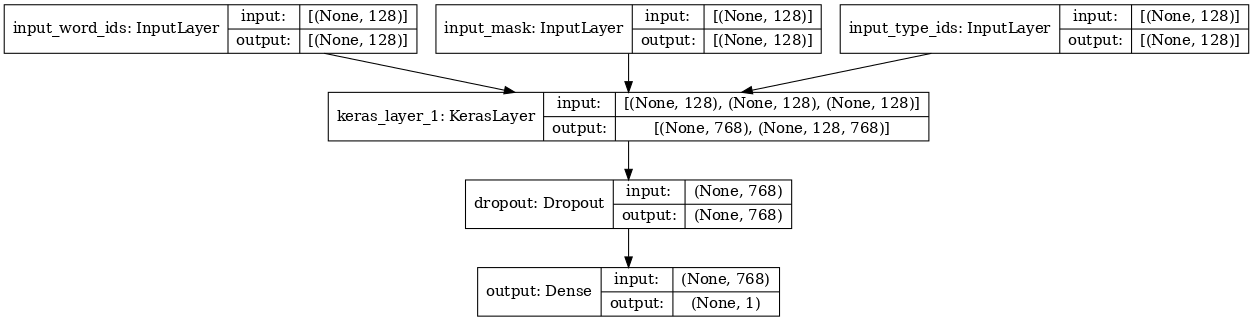

In [95]:
# model - image
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76, )

In [96]:
# Update CONFIG dict with the name of the model.
config['model_name'] = 'BERT_EN_UNCASED'
print('Training configuration: ', config)


# Initialize W&B run
run = wandb.init(project='Finetune-BERT-Text-Classification', 
                 config=config,
                 group='BERT_EN_UNCASED', 
                 job_type='train')


Training configuration:  {'label_list': [0, 1], 'max_seq_length': 128, 'train_batch_size': 32, 'learning_rate': 2e-05, 'epochs': 5, 'optimizer': 'adam', 'dropout': 0.5, 'train_samples': 2000, 'valid_samples': 180, 'train_split': 0.1, 'valid_split': 0.01, 'model_name': 'BERT_EN_UNCASED'}


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [97]:
# Train model
# setting low epochs as It starts to overfit with this limited data, please feel free to change
epochs = config['epochs']
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=epochs,
                    verbose=1,
                    callbacks = [WandbCallback()])
run.finish()


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.
2022-11-29 08:58:14.395506: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-29 08:58:15.353885: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2022-11-29 08:58:15.354243: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-11-29 08:58:15.549778: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1137] Optimization results for grappler item: graph_to_optimize
  function_optimizer: Graph size after: 837 nodes (6

Epoch 1/5
62/62 [==============================] - 1410s 22s/step - loss: 0.7336 - binary_accuracy: 0.5156 - precision_at_recall_1: 0.5152 - precision_1: 0.5146 - recall_1: 0.5348 - val_loss: 0.6382 - val_binary_accuracy: 0.6375 - val_precision_at_recall_1: 0.7288 - val_precision_1: 0.6579 - val_recall_1: 0.6098
Epoch 2/5
62/62 [==============================] - 1378s 22s/step - loss: 0.6348 - binary_accuracy: 0.6331 - precision_at_recall_1: 0.6684 - precision_1: 0.6322 - recall_1: 0.6347 - val_loss: 0.5270 - val_binary_accuracy: 0.7250 - val_precision_at_recall_1: 0.8627 - val_precision_1: 0.7262 - val_recall_1: 0.7439
Epoch 3/5
62/62 [==============================] - 1377s 22s/step - loss: 0.5046 - binary_accuracy: 0.7445 - precision_at_recall_1: 0.8463 - precision_1: 0.7452 - recall_1: 0.7445 - val_loss: 0.5079 - val_binary_accuracy: 0.7250 - val_precision_at_recall_1: 0.8913 - val_precision_1: 0.7436 - val_recall_1: 0.7073
Epoch 4/5
62/62 [==============================] - 1382s 2

binary_accuracy,▁▃▅▇█
epoch,▁▃▅▆█
loss,█▇▅▃▁
precision_1,▁▃▅▆█
precision_at_recall_1,▁▃▆██
recall_1,▁▃▅▆█
val_binary_accuracy,▁██▇█
val_loss,▄▁▁▄█
val_precision_1,▁▇█▃▅
val_precision_at_recall_1,▁▇█▆█
val_recall_1,▁▅▄█▇


In [98]:
# Initialize a new run for the evaluation-job
run = wandb.init(project='Finetune-BERT-Text-Classification', 
                 config=config,
                 group='BERT_EN_UNCASED', 
                 job_type='evaluate')

# Model Evaluation on validation set
evaluation_results = model.evaluate(valid_data,return_dict=True)


# Log scores using wandb.log()
wandb.log(evaluation_results)


# Finish the run
run.finish()


wandb: Currently logged in as: zhiwang. Use `wandb login --relogin` to force relogin


5/5 [==============================] - 45s 9s/step - loss: 0.8139 - binary_accuracy: 0.7250 - precision_at_recall_1: 0.8800 - precision_1: 0.7065 - recall_1: 0.7927


binary_accuracy,▁
loss,▁
precision_1,▁
precision_at_recall_1,▁
recall_1,▁
binary_accuracy,0.725
loss,0.81388
precision_1,0.70652
precision_at_recall_1,0.88
recall_1,0.79268


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9a6749d3-7805-4e72-9b13-9d4cebfc5e43' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>